<a href="https://colab.research.google.com/github/chonholee/tutorial/blob/main/bigdata/KaggleSample_HousePrices_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Price Prediction in IOWA Dataset

# 1 ライブラリインポート

In [17]:
# numpy , pandas
import numpy as np 
import pandas as pd

# scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 可視化用ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns

#pandasのカラムが100列まで見れるようにする
pd.set_option('display.max_columns', 100)

# 2 学習データの読み込み

In [ ]:
# 学習データの読み込み
train_df = ---here ---

# データセットサイズの確認
---here ---

# 先頭5行をみてみる。
---here ---

In [ ]:
#欠損値の確認
---here ---

In [ ]:
# タイプの確認
---here ---

# 3 EDA (探索的データ分析)

データセットを分析・調査して主な特性を要約するための分析で、データ可視化の手法としてよく使われる。

データから何を読み取れるかを見出すのに用いられ、データセットの変数と変数間の関連をよりよく理解するのに有効であり、事前にパターンを発見し、異常を特定し、仮説をテストし、前提条件を確認することで、目的達成のためのデータセットの最適な処理方法を決定するのに役立つ。


## 変数について

データ詳細 (変数定義)

目的変数(本課題で予測する値) - 1個
* SalePrice : 住宅価格

説明変数(予測に使う変数) - 79個 一部抜粋

住宅価格に大きく影響しそうな変数
* LotArea : 敷地面積
* YearBuilt : 建築年
* YearRemodAdd : リフォーム年

住宅価格にある程度影響しそうな変数
* KitchenQual : キッチンの状態
* RoofMatl : 屋根の材質

アメリカっぽいやつも。。。
* HeatingQC : 暖炉の状態
* PoolArea : プールの広さ

In [ ]:
# 変数リスト
---here ---

## 売却価格（目的変数）について

In [ ]:
# 売却価格のヒストグラム
sns.distplot(train_df['SalePrice'])

# 売却価格の概要をみてみる
print(train_df["SalePrice"].describe())
print(f"歪度: {round(train_df['SalePrice'].skew(),4)}" )
print(f"尖度: {round(train_df['SalePrice'].kurt(),4)}" )

価格の低い物件が大多数を占めていそう... **---> 正規分布に従わない分布**

**歪度(わいど)**

分布を正規分布と比較したときの偏り度合い(非対称性)を示す尺度。0に近いほど左右対称。


**尖度(せんど)**

分布を正規分布と比較したときの尖り具合を示す尺度。0に近いほど正規分布に近い。
また、正の大きい値をとるほど、ピーク付近に標本が集中しており、負の大きい値をとるほど、分布が散らばっている。

参考：歪度と尖度 - 統計Web

# 4 データ前処理

前処理は学習用データセットと予測用データセットを合わせて同時に行う。
(ただし、予測データは全ての行を残す必要があるため、外れ値の除去はしない。)

In [ ]:
# 予測用データセットの読み込み
test_df = ---here ---

all_df = pd.concat([train_df.drop(columns='SalePrice'), test_df])
test_df.head()

## 4.1 一部の数字が入っている変数を文字列に変換

変数の値に数字が入っている場合、数字の大小関係が予測に影響を与えない方が良いものはカテゴリ変数にすべき → 文字列に変更しておく

例：血液型の変数が{'A' : 0 ,'B' : 1 , 'O' : 3 , 'AB' : 4 }と割り当てられている場合、数の大小に意味はない

In [ ]:
# 例えば
all_df['MSSubClass']

In [26]:
num2str_list = ['MSSubClass','YrSold','MoSold']
for column in num2str_list:
    all_df[column] = all_df[column].astype(str)

## 4.2 欠損値の処理

欠損値の処理には、主に以下の2つがある。

欠損値を含む行または列の削除、もしくは欠損値を代表値などで埋める

今回のデータでは欠損値となっている箇所は、その設備がない場合である。

例：PoolAreaが欠損している物件はそもそもプールがない。

そこで今回は、数字の変数の欠損は「0」、文字列の変数の欠損は「'None'」で埋めるものとする。

In [ ]:
# 変数の型ごとに欠損値の扱いが異なるため、列ごとに処理
for column in all_df.columns:

    # dtypeがobjectの場合、文字列の変数
    if all_df[column].dtype=='O':
        all_df[column] = all_df[column].fillna('None')
  
    # dtypeがint , floatの場合、数字の変数
    else:
        all_df[column] = all_df[column].fillna(0)

all_df.info()

## 4.3 特徴量エンジニアリング

予測に効果的そうな新しい変数を追加

例：建物内の総面積 = 1階の面積 + 2階の面積 + 地下の面積

In [29]:
def add_new_columns(df):
    # 建物内の総面積 = 1階の面積 + 2階の面積 + 地下の面積
    df["TotalSF"] = df["1stFlrSF"] + df["2ndFlrSF"] + df["TotalBsmtSF"]
    
    # 一部屋あたりの平均面積 = 建物の総面積 / 部屋数
    df['AreaPerRoom'] = df['TotalSF']/df['TotRmsAbvGrd']
    
    # 築年数 + 最新リフォーム年 : この値が大きいほど値段が高くなりそう
    df['YearBuiltPlusRemod']=df['YearBuilt']+df['YearRemodAdd']
    
    # お風呂の総面積
    # Full bath : 浴槽、シャワー、洗面台、便器全てが備わったバスルーム
    # Half bath : 洗面台、便器が備わった部屋)(シャワールームがある場合もある)
    # シャワーがない場合を想定してHalf Bathには0.5の係数をつける
    df['TotalBathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    
    # 合計の屋根付きの玄関の総面積 
    # Porch : 屋根付きの玄関 日本風にいうと縁側
    df['TotalPorchSF'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])
    
    # プールの有無
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    
    # 2階の有無
    df['Has2ndFloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    
    # ガレージの有無
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    
    # 地下室の有無
    df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    
    # 暖炉の有無
    df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


In [ ]:
# 関数実行
add_new_columns(all_df)

all_df

## 4.4 文字列のカテゴリ変数化(One-Hot-Encoding)
文字列のままでは、正規化したり機械学習にかけられないので、One-Hot-Encodingによりカテゴリ変数化する。
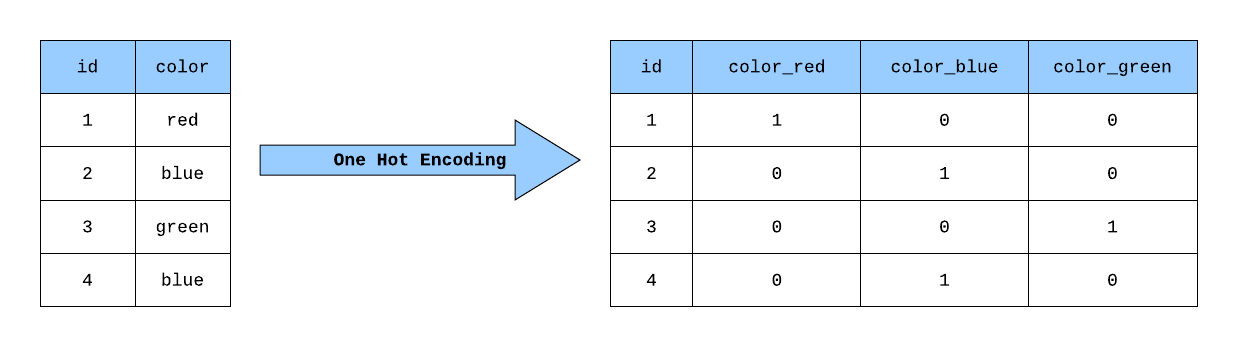

One-Hot-Encoding

出典：Building a One Hot Encoding Layer with TensorFlow


In [ ]:
# One-Hot-Encoding前の列数
print(len(all_df.columns))

# pd.get_dummiesを使うとカテゴリ変数できる。
all_df = pd.get_dummies(all_df)

# One-Hot-Encoding後の列数
print(len(all_df.columns))

In [ ]:
all_df

余談

カテゴリ変数に大小の意味を持たせたい場合はOrdinal Encoding(Label Encoding)を用いるとよい。

Ordinal Encoding例： テストの結果に基づいた評定　90 ~ :'S',　80 ~ 89 :'A',　70 ~ 79 :'B', ~ 70:'C'　の時は大小関係に意味がある。

参考：カテゴリカル変数はなんでもダミー変換すればよいのか？-アルゴリズムに応じたOne Hot EncodingとLabel Encodingの使い分け

One-Hot-Encodingによって、変数が過剰に増えてしまうことを防ぐために、Ordinal Encodingを用いることもある。

## 4.5 外れ値の除去

学習データから特異な物件のデータは削除しておく。(予測データの物件は削除できないので、学習データに対してのみ実施)

例：一般の住宅のデータにハリウッドスターの物件のデータが入っていると（物件が特異なので）そのデータに予測が影響を受けてしまう。

In [33]:
# 学習データと予測データに分割して元のデータフレームに戻す。
train_df = pd.merge(all_df.iloc[train_df.index[0]:train_df.index[-1]],train_df['SalePrice'],left_index=True,right_index=True)
test_df = all_df.iloc[train_df.index[-1]:]

外れ値の条件は以下に設定し、該当する物件のデータを削除

* 物件の価格が400000ドル以上
* 敷地面積が20000平方メートル以上
* 建築年が1920年より前

In [34]:
train_df = train_df[(train_df['LotArea']<20000) & (train_df['SalePrice']<400000)& (train_df['YearBuilt']>1920)]

## 4.6 住宅価格を対数変換

多くの機械学習アルゴリズムは正規分布のデータを想定しているため、正規分布ではないデータに対して精度が出ない場合が多い。

→ 正規分布に従わない変数の対数をとると、正規分布に近付くことが多い。(そのような分布を対数正規分布と呼ぶ。)

In [ ]:
# 対数変換前のヒストグラム、歪度、尖度
sns.distplot(train_df['SalePrice'])
print(f"歪度: {round(train_df['SalePrice'].skew(),4)}" )
print(f"尖度: {round(train_df['SalePrice'].kurt(),4)}" )

In [ ]:
# SalePriceLogに対数変換した値を入れる。説明の都合上新たなカラムを作るが、基本的にそのまま代入して良い。
train_df['SalePriceLog'] = np.log(train_df['SalePrice'])

# 対数変換後のヒストグラム、歪度、尖度
sns.distplot(train_df['SalePriceLog'])
print(f"歪度: {round(train_df['SalePriceLog'].skew(),4)}" )
print(f"尖度: {round(train_df['SalePriceLog'].kurt(),4)}" )


ぱっと見わかりづらいが、歪度、尖度をみるとかなり正規分布に近づいたことがわかる。

余談

元の目的変数の分布によっては対数変換が意味をなさない、または悪影響を与える場合がある。

参考：対数変換が適さない場合がある！？対数変換すると結果が悪くなる例の紹介


## 4.7 学習データの説明変数と目的変数、予測データの説明変数にデータフレームを分割する

In [37]:
# 学習データ、説明変数
train_X = train_df.drop(columns = ['SalePrice','SalePriceLog'])
# 学習データ、目的変数
train_y = train_df['SalePriceLog']

# 予測データ、説明変数
test_X = test_df

# 5 モデルの作成、学習

学習データの傾向を学習し、モデルを作成する。

今回は機械学習アルゴリズムとしてラッソ回帰(Lasso Regression)を用いる。Wikipedia で概要を確認！

ラッソ回帰を選んだ理由

変数の数が多く、少数の変数が予測に大きな影響を与えそうな場合に有効 (敷地面積とか築年数が影響を与えそう。。。)

ハイパーパラメータがalphaのパラメータだけ調整すれば上手く学習できそう。

## 5.1 ハイパーパラメータチューニング

交差検証(Grid Search)を用いて、ハイパーパラメータのalphaをチューニング
lasso_tuning -> 学習データ内でホールドアウト検証をして、最も精度の高かったalphaのパラメータを返す。

In [38]:
def lasso_tuning(train_x,train_y):
    # alphaパラメータのリスト
    param_list = [0.001, 0.01, 0.1, 1.0, 10.0,100.0,1000.0] 
    
    for cnt,alpha in enumerate(param_list):
        # パラメータを設定したラッソ回帰モデル
        lasso = Lasso(alpha=alpha) 
        # パイプライン生成
        pipeline = make_pipeline(StandardScaler(), lasso)
        
        # 学習データ内でホールドアウト検証のために分割 テストデータの割合は0.3 seed値を0に固定
        X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, random_state=0)
        
        # 学習
        pipeline.fit(X_train,y_train)
        
        # RMSE(平均誤差)を計算
        train_rmse = np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))
        test_rmse = np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test)))
        # ベストパラメータを更新
        if cnt == 0:
            best_score = test_rmse
            best_param = alpha
        elif best_score > test_rmse:
            best_score = test_rmse
            best_param = alpha
    
    # ベストパラメータのalphaと、そのときのMSEを出力
    print('alpha : ' + str(best_param))
    print('test score is : ' +str(round(best_score,4)))
    
    # ベストパラメータを返却
    return best_param

In [ ]:
# チューニング実行
best_alpha = lasso_tuning(train_X,train_y)

最も精度が出たalphaは「0.01」、RMSE(平均二乗平方根誤差)は「0.0985」

## 5.2 ベストパラメータを用いてモデル作成
交差検証の結果をもとに、最優秀alphaをパラメータに設定して学習

In [ ]:
# ラッソ回帰モデルにベストパラメータを設定
lasso = Lasso(alpha = best_alpha)

# パイプラインの作成
pipeline = make_pipeline(StandardScaler(), lasso)

# 学習
pipeline.fit(train_X,train_y)

In [ ]:
from sklearn.tree import DecisionTreeRegressor # 回帰木モデルを作成するクラス

# 決定木
dtr = ---here ---
---here ---

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfr = ---here ---
---here ---

In [ ]:
!pip install xgboost

import xgboost

xgb = ---here ---
---here ---

In [44]:
# SVM
#from sklearn.svm import SVR
#clf = SVR(kernel="linear")
#clf.fit(train_X, train_y)

# 6 住宅価格予測

## 6.1 作成したモデルで住宅価格を予測する。

In [45]:
# Lasso回帰
pred = pipeline.predict(test_X)

In [46]:
# Decision Tree
pred_dtr = ---here ---

# Random Forest
pred_rfr = ---here ---

# XGBoost for Regression
pred_xgb = ---here ---

# SVM
#pred_svm = clf.predict(test_X)

In [ ]:
result = pd.DataFrame({"lasso":pred, "dtr":pred_dtr, "rfr": pred_rfr, "xgb":pred_xgb})
result

## 6.2 予測結果を指数変換

予測結果のヒストグラムをみてみる。

In [ ]:
# 予測結果のプロット
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 4))
sns.distplot(pred, ax=ax1)
ax1.set_title("lasso")
sns.distplot(pred_dtr, ax=ax2)
ax2.set_title("dtr")
sns.distplot(pred_rfr, ax=ax3)
ax3.set_title("rfr")
sns.distplot(pred_xgb, ax=ax4)
ax4.set_title("xgb")

# 歪度と尖度
for i in range(result.shape[1]):
  print(result.columns[i])
  print(f"歪度: {round(pd.Series(result.iloc[:,i]).skew(),4)}")
  print(f"尖度: {round(pd.Series(result.iloc[:,i]).kurt(),4)}")

#print(f"歪度: {round(pd.Series(pred_xgb).skew(),4)}" )
#print(f"尖度: {round(pd.Series(pred_xgb).kurt(),4)}" )

これは「4.6　住宅価格を対数変換」で対数変換した値なので、逆に指数変換して戻してあげる必要がある。


In [ ]:
# 指数変換
pred_exp = np.exp(pred)
pred_exp_dtr = np.exp(pred_dtr)
pred_exp_rfr = np.exp(pred_rfr)
pred_exp_xgb = np.exp(pred_xgb)

result = pd.DataFrame({"lasso":pred_exp, "dtr":pred_exp_dtr, "rfr": pred_exp_rfr, "xgb":pred_exp_xgb})

# 指数変換した予測結果をプロット
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(13, 4))
sns.distplot(pred_exp, ax=ax1)
ax1.set_title("lasso")
sns.distplot(pred_exp_dtr, ax=ax2)
ax2.set_title("dtr")
sns.distplot(pred_exp_rfr, ax=ax3)
ax3.set_title("rfr")
sns.distplot(pred_exp_xgb, ax=ax4)
ax4.set_title("xgb")

# 歪度と尖度
for i in range(result.shape[1]):
  print(result.columns[i])
  print(f"歪度: {round(pd.Series(result.iloc[:,i]).skew(),4)}")
  print(f"尖度: {round(pd.Series(result.iloc[:,i]).kurt(),4)}")



めちゃくちゃ高い物件があってみづらいので、一旦外れ値除去してプロット

In [ ]:
# 400,000より高い物件は除去
pred_exp_ex_outliars = pred_exp[pred_exp<400000]
pred_exp_xgb_ex_outliars = pred_exp_xgb[pred_exp_xgb<400000]

# 指数変換した予測結果をプロット
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.distplot(pred_exp_ex_outliars, ax=ax1)
ax1.set_title("lasso")
sns.distplot(pred_exp_xgb_ex_outliars, ax=ax2)
ax2.set_title("xgb")


# 歪度と尖度
print(f"歪度: {round(pd.Series(pred_exp_ex_outliars).skew(),4)}" )
print(f"尖度: {round(pd.Series(pred_exp_ex_outliars).kurt(),4)}" )
print(f"歪度: {round(pd.Series(pred_exp_xgb_ex_outliars).skew(),4)}" )
print(f"尖度: {round(pd.Series(pred_exp_xgb_ex_outliars).kurt(),4)}" )

学習データの住宅価格の分布と比較


In [ ]:
# 学習データの住宅価格をプロット
sns.distplot(train_df['SalePrice'])
# 歪度と尖度
print(f"歪度: {round(pd.Series(train_df['SalePrice']).skew(),4)}" )
print(f"尖度: {round(pd.Series(train_df['SalePrice']).kurt(),4)}" )

学習データの住宅価格とテストデータによる予測の分布がかなり似てる！気がする！

# 7 提出用csvを作成

基本は予測結果を代入するだけでOK。(予測結果の個数が間違っているとエラーになるので、チェックにもなる。)

In [ ]:
submission_df = pd.DataFrame()
submission_df['Id'] = test_df.index
submission_df['SalePrice'] = pred_exp
submission_df.head(10)

csvを出力する。(必ず index=False とすること！)

In [53]:
submission_df.to_csv('sample_data/submission.csv',index=False)

csvをダウンロードして提出！